# 2D ERT modeling and inversion
## This one tries to copy the deposit shape and do a better image of the geothermal plume


I'll try to add the geothermal plume as a diffusing body, meanwhile I'll keep the plume the same as the simple model.

In [49]:
import matplotlib.pyplot as plt
import numpy as np

import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

print(pg.Report())


--------------------------------------------------------------------------------
  Date: Mon Aug 28 16:20:27 2023 -05

                OS : Linux
            CPU(s) : 12
           Machine : x86_64
      Architecture : 64bit
               RAM : 7.5 GiB
       Environment : Jupyter
       File system : ext4

  Python 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32)
  [GCC 12.3.0]

           pygimli : 1.4.3
            pgcore : 1.4.0
             numpy : 1.25.0
        matplotlib : 3.7.2
             scipy : 1.11.1
           IPython : 8.14.0
           pyvista : 0.41.1
--------------------------------------------------------------------------------


## Geometry definition

Create deposit shape

(<Axes: >, None)

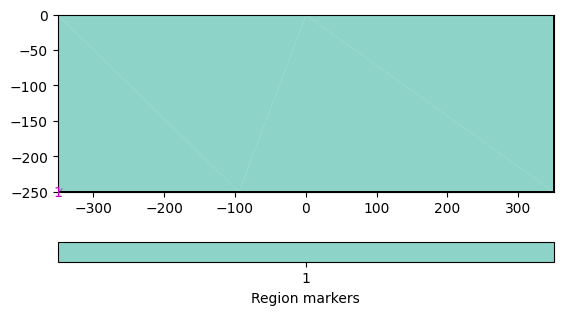

In [50]:
world = mt.createWorld(start=[-350, 0], end=[350, -250], layers=[],
                       worldMarker=1)
pg.show(world)

Calculate fault points position


In [51]:
x1 = -125
y2 = -250

#Find y1 and x2 so fault intersects with first layer base and it has dip = 60°

def f(p):
    x2, y1 = p
    eq1 = y1 - (-150 + 50 * np.sin((x1-300) / 200))
    eq2 = x2 - (x1 + (y2 - y1) / np.tan(np.radians(60)))
    return [eq1, eq2]

from scipy.optimize import fsolve

x2, y1 = fsolve(f, [-100, -200])

Define Floresta Formation

(<Axes: >, None)

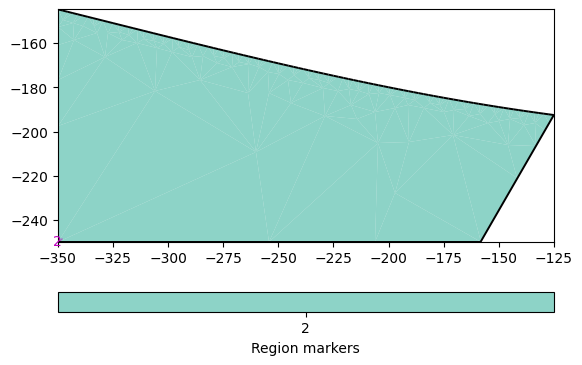

In [52]:
x_top = np.linspace(-350, x1, 100)
y_top = -150 + 50 * np.sin((x_top-300) / 200)

Floresta_top = np.column_stack((x_top,y_top))[::-1]
Floresta_bottom = [[-350, y2], [x2, y2]]
Floresta_verts = np.vstack((Floresta_bottom, Floresta_top))
floresta_fm = mt.createPolygon(Floresta_verts, isClosed = True, marker = 2)
pg.show(floresta_fm)

Define Cretacic Rocks

(<Axes: >, None)

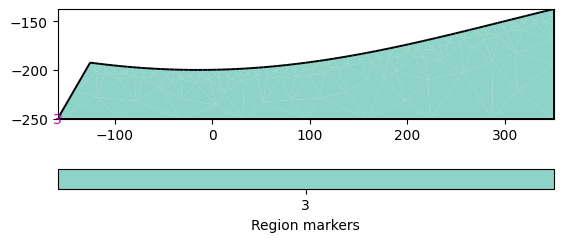

In [53]:
x_top2 = np.linspace(x1, 350, 100)
y_top2 = -150 + 50 * np.sin(((x_top2-300) / 200))

Cretacic_top = np.column_stack((x_top2,y_top2))[::-1]
Cretacic_bottom = [[x2, y2], [350, y2]]
Cretacic_verts = np.vstack((Cretacic_bottom, Cretacic_top))
cretacic_rocks = mt.createPolygon(Cretacic_verts, isClosed = True, marker = 3)
pg.show(cretacic_rocks)

Define fault

In [54]:
fault_verts = [[x1, y1], [x2, y2]]
fault = mt.createPolygon(fault_verts, isClosed=True, marker=4)

Create final mesh

In [55]:
bodies = [world, floresta_fm, cretacic_rocks, fault]

# Create the final mesh
mesh = mt.createMesh(bodies)

Optional: show the geometry

(<Axes: >, None)

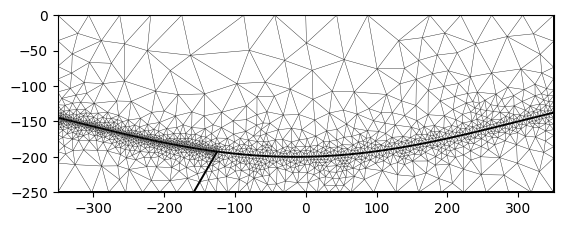

In [56]:
pg.show(mesh)

Hydraulic properties to define aquifer and geothermal plume

In [57]:
K = pg.solver.parseMapToCellArray([1e-8, 1e-8, 1e-8], mesh) # in m/s
K[mesh.cellMarkers() == 6] = 1e-6 # in m/s

# Solve the Darcy equation to obtain hydraulic potential and velocity
pBound = [pg.RVector3(-350.0, 0.0), pg.RVector3(-350.0, -250.0), pg.RVector3(350.0, -250.0), pg.RVector3(350.0, 0.0)]
pBoundValue = [10.0, 10.0, 0.0, 0.0] # in m

p = pg.solver.solveFiniteElements(mesh,
                                  a=K,
                                  f=0,
                                  bc={'Dirichlet': pBound},
                                  bcValues=pBoundValue)
u = -pg.solver.grad(mesh,p) * K

# Plot hydraulic potential and velocity
ax1,_= pg.show(mesh,p)
ax2,_= pg.show(mesh,u)

28/08/23 - 16:20:45 - pyGIMLi - WARNING - parseMapToCellArray: cannot find marker 1e-08 within mesh.


Exception: ('cannot interpret boundary token', [RVector3: (-350.0, 0.0, 0.0), RVector3: (-350.0, -250.0, 0.0), RVector3: (350.0, -250.0, 0.0), RVector3: (350.0, 0.0, 0.0)])

## Synthetic data generation
Create a Schlumberger ('slm') measuring scheme with 96 electrodes along a 700m line (-350 to 350)


In [ ]:
scheme = ert.createData(elecs=np.linspace(start=-350, stop=350, num=96),
                           schemeName='slm')

Put all electrode (aka sensors) positions into the PLC to enforce mesh
refinement. Due to experience, its convenient to add further refinement
nodes in a distance of 10% of electrode spacing to achieve sufficient
numerical accuracy.



In [ ]:
for p in scheme.sensors():
    geom.createNode(p)
    geom.createNode(p - [0, 0.1])

# Create a mesh for the finite element modelling with appropriate mesh quality.
mesh = mt.createMesh(geom, quality=34)

# Define resistivity values for different regions
A = 500.  # Resistivity of siliciclastic rocks (Quartz sandstone, clear, with conglomeratic layers)
B = 80.   # Resistivity of a quaternary aquifer with fresh water
C = 100.   # Resistivity of Limolite and shale
D = 50.    # Resistivity of outer plume
E = 25.    # Resistivity of middle plume
F = 1.     # Resistivity of inner plume

# Create a map to set resistivity values in the appropriate regions
rhomap = [[0, B],
          [2, C],
          [3, A],
          [4, D],
          [5, E],
          [6, F]]

# Take a look at the mesh and the resistivity distribution
pg.show(mesh, data=rhomap, label=pg.unit('res'), showMesh=True)

Perform the modeling with the mesh and the measuring scheme itself
and return a data container with apparent resistivity values,
geometric factors and estimated data errors specified by the noise setting.
The noise is also added to the data. Here 3% plus 1µV.
Note, we force a specific noise seed as we want reproducable results for
testing purposes.



In [ ]:
data = ert.simulate(mesh, scheme=scheme, res=rhomap, noiseLevel=3,
                    noiseAbs=1e-6, seed=1337)

pg.info(np.linalg.norm(data['err']), np.linalg.norm(data['rhoa']))
pg.info('Simulated data', data)
pg.info('The data contains:', data.dataMap().keys())

pg.info('Simulated rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))
pg.info('Selected data noise %(min/max)', min(data['err'])*100, max(data['err'])*100)

Optional: you can filter all values and tokens in the data container.
Its possible that there are some negative data values due to noise and
huge geometric factors. So we need to remove them.



In [ ]:
data.remove(data['rhoa'] < 0)
pg.info('Filtered rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))

# You can save the data for further use
data.save('Forward_mod.dat')

# You can take a look at the data
ert.show(data)

## Inversion with the ERTManager
Initialize the ERTManager, e.g. with a data container or a filename.



In [ ]:
mgr = ert.ERTManager('Forward_mod.dat')

Run the inversion with the preset data. 
Since I set noise level to 3%, chi^2 target should be close to 0.9 or sighly above, also the regularization parameter should be in the range of 10 to 50 (I chose 30).



In [ ]:
inv = mgr.invert(lam=30, verbose=True)
np.testing.assert_approx_equal(mgr.inv.chi2(), 0.9, significant=1)

Let the ERTManger show you the model of the last successful run and how it
fits the data. 
## Show data, model response, and model.



In [ ]:
mgr.showResultAndFit()
meshPD = pg.Mesh(mgr.paraDomain) # Save copy of para mesh for plotting later